In [1]:
from utils.transforms import *

In [267]:
import imgaug.augmenters as iaa
from torchvision import transforms as T
import numpy as np
from imgaug.augmenters import Augmenter
import cv2

In [57]:
from random import uniform

In [ ]:
class Crop(Augmenter):
    def __init__(self, box_csv, extend_share=(0,1), name=None, deterministic=False, random_state=None):
        super(Crop, self).__init__(name=name, deterministic=deterministic, random_state=random_state)
        self.box_csv = 
        

    def _augment_images(self, images, random_state, parents, hooks):
        for i in range(nb_images):
            if samples[i] == 1:
                images[i] = np.fliplr(images[i])
        return images

    def get_parameters(self):
        return [self.p]

In [ ]:
def crop_img(img):
    return img[:50,:50,:]

def func_images(images, random_state, parents, hooks):
    images = [crop_img(images[i]) for i in range(len(images))]
    return images
    
def func_heatmaps(heatmaps, random_state, parents, hooks):
    return heatmaps
    
def func_keypoints(keypoints_on_images, random_state, parents, hooks):
    return keypoints_on_images

crop_augmenter = iaa.Lambda(
    func_images=func_images,
)

aug = iaa.Sequential([iaa.Fliplr(0.5), crop_augmenter(d=1), iaa.Sometimes(0.2, iaa.AverageBlur(k=(3,3)))]).augment_image

In [51]:
img = np.random.rand(100, 100, 3)

In [ ]:
img_ = aug(img)

In [45]:
img_.shape

(50, 50, 3)

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from utils import get_augmentation_list, TrainImageDataset, TestImageDataset, DummyDataset3
import os

In [2]:
data_csv = pd.read_csv("/home/kutsenko/projects/happywhale/data/train_.csv")
data_csv['image'] = data_csv['image'].apply(lambda x: x.replace('.jpg', '.png'))
dataset = TrainImageDataset(data_csv,
                            '/home/kutsenko/kaggle/segmented/seg_img',
                            transform=None,
                            min_class_num=8,
                            img_size=(256, 256))
# dataset = TestImageDataset('/home/kutsenko/kaggle/segmented/seg_img_test',
#                             transform=None)


In [3]:
from ffcv.fields import RGBImageField, BytesField, IntField, NDArrayField
from ffcv.writer import DatasetWriter


write_path = '/home/kutsenko/kaggle/ffcv/seg_train0.beton'


# writer = DatasetWriter(write_path, {
#     'image': RGBImageField(),
#     'img_name': BytesField()
# }, num_workers=10)
writer = DatasetWriter(write_path, {
    'image': RGBImageField(),
    'label': IntField()
}, num_workers=10)

writer.from_indexed_dataset(dataset)
writer.from_indexed_dataset(dataset)

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 25485/25485 [02:19<00:00, 182.78it/s]


In [2]:
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, ToTorchImage
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder, BytesDecoder
from PIL.Image import fromarray
from torch import nn
import torch
from random import uniform

In [3]:
write_path = '/home/kutsenko/kaggle/ffcv/seg_train2.beton'

In [343]:
import numpy as np
from kornia.augmentation import *
from kornia.augmentation.container import AugmentationSequential
import cv2


class Augmenter(nn.Module):
    def __init__(self):
        super().__init__()
        self.aug_list = AugmentationSequential(
            RandomHorizontalFlip(p=0.5),
            AugmentationSequential(RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.2, 1.5), p=0.5),
                                   RandomMotionBlur(kernel_size=(3, 3), angle=(-90,90), direction=0, p=0.5),
                                   random_apply=1),
            ColorJitter(brightness=(0.95, 1.2),
                        contrast=(0.8, 1.3),
                        saturation=(0.7, 1.3),
                        hue=0.01,
                        p=0.6),
            AugmentationSequential(RandomThinPlateSpline(scale=0.2, p=0.65),
                                   RandomRotation(degrees=(-15, 15), p=0.65),
                                   RandomPerspective(distortion_scale=0.2, p=0.65),
                                   random_apply=1),
            
            AugmentationSequential(RandomErasing(scale=(0.02, 0.07), ratio=(0.7, 1.3), value=0.0, p=0.3),
                                   RandomErasing(scale=(0.015, 0.07), ratio=(0.7, 1.3), value=0.0, p=0.2),
                                   RandomErasing(scale=(0.015, 0.07), ratio=(0.7, 1.3), value=0.0, p=0.2),
                                   )
            
            
        )
    
    def forward(self, x):
        return self.aug_list(x.type(torch.float32) / 255.)
    

In [344]:
image_pipeline = [SimpleRGBImageDecoder(), ToTensor(), ToTorchImage(), Augmenter()]
# image_pipeline = [SimpleRGBImageDecoder(), ToTensor(), ToTorchImage()]
label_pipeline = [IntDecoder()]

pipelines = {
    'image': image_pipeline,
    'label': label_pipeline
}

loader = Loader(write_path, batch_size=1, num_workers=1,
                order=OrderOption.SEQUENTIAL, pipelines=pipelines)



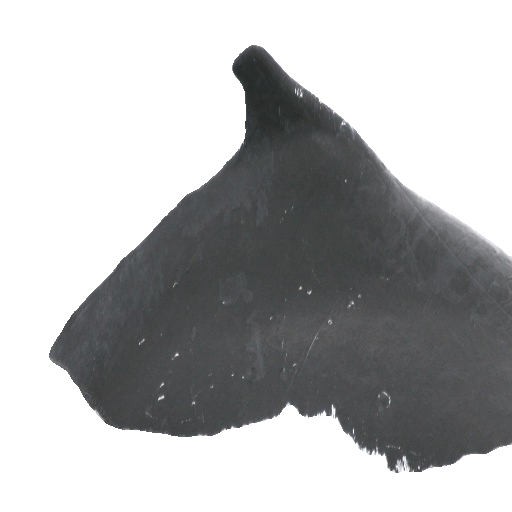

In [353]:
for i, x in loader:
    img = np.moveaxis((i[0] * 255.).type(torch.uint8).numpy(), 0, -1)
    # img = i[0]
    break

fromarray(img)

In [2]:
from modules.schedulers import RampScheduler
import matplotlib.pyplot as plt

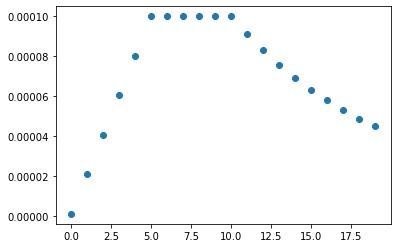

In [165]:
lr_start = 0.000001
lr_max = 0.0001
lr_min = 0.00001
lr_ramp_ep = 5
lr_sus_ep = 5
lr_decay = 0.9

batch_size = 32

scheduler = RampScheduler(batch_size=batch_size,
                          lr_start=lr_start,
                          lr_max=lr_max,
                          lr_min=lr_min,
                          lr_ramp_ep=lr_ramp_ep,
                          lr_sus_ep=lr_sus_ep,
                          lr_decay=lr_decay)

# class DecayScheduler():
#     def __init__(self, base_lr, decay, step):
#         # super(DecayScheduler, self).__init__()
#         self.step  = step
#         self.decay = decay
#         self.base_lr = base_lr

#     def __call__(self, epoch):
#         lr = self.base_lr * (self.decay**(epoch // self.step))
#         return lr

# scheduler = DecayScheduler(0.0001, 0.9, 1)

epochs = list(range(20))
learning_rates = [scheduler(x) for x in epochs]
plt.scatter(epochs,learning_rates)
plt.show()

In [164]:
learning_rates[:-1]

[1e-06,
 2.08e-05,
 4.06e-05,
 6.04e-05,
 8.02e-05,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 9.1e-05,
 8.290000000000001e-05,
 7.561000000000002e-05,
 6.904900000000001e-05,
 6.314410000000001e-05,
 5.7829690000000006e-05,
 5.3046721000000006e-05,
 4.874204890000001e-05]

In [130]:
class ResolutionScheduler:
    def __init__(self, min_res=256, max_res=512, start_ramp=4, end_ramp=15):
        assert min_res <= max_res
        
        self.min_res = min_res
        self.max_res = max_res
        self.start_ramp = start_ramp
        self.end_ramp = end_ramp
    
    def __call__(self, epoch):
        if epoch < self.start_ramp:
            return self.min_res

        if epoch > self.end_ramp:
            return self.max_res
        
        # otherwise, linearly interpolate to the nearest multiple of 32
        interp = np.interp([epoch], [self.start_ramp, self.end_ramp], [self.min_res, self.max_res])
        res = int(np.round(interp[0] / 32)) * 32
        return res
        

In [141]:
min_res = 128
max_res = 256
start_ramp = 3
end_ramp = 12

res_scheduler = ResolutionScheduler(min_res, max_res, start_ramp, end_ramp)

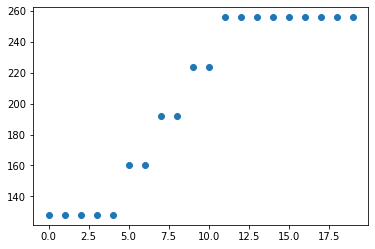

In [142]:
epochs = list(range(20))
resolutions = [res_scheduler(x) for x in epochs]
plt.scatter(epochs,resolutions)
plt.show()